# Proyecto 1 Inteligencia de Negocios - Analítica de Textos
**Equipo consultor:**
* Juan José Beltrán Ruiz - 201819446 - jj.beltran@uniandes.edu.co
* Santiago Bobadilla Suárez - 201820728 - s.bobadilla@uniandes.edu.co

Usar este link para hacer análisis importantes en el tratamiento de datos
https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

## Parte 0: Librerías necesarias

In [1]:
!pip install pandas==1.2.2

In [2]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions

In [3]:
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect

In [4]:
# Librería adicional para el manejo de matrices
!pip install pandas-profiling==2.7.1

In [5]:
# librería Natural Language Toolkit, usada para trabajar con textos 
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Importamos las librerias
import pandas as pd
import numpy as np
import sys
from pandas_profiling import ProfileReport

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, plot_precision_recall_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold 

from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

## Parte 1: Perfilamiento y Entendimiento de Datos

In [9]:
# Se leen los datos
data=pd.read_csv('medical_text_clasificacion.csv', sep=',', encoding = 'utf-8')
data

,medical_abstracts,problems_described
0,Cell lineage markers in human pancreatic cance...,1
1,Fatal pulmonary venoocclusive disease secondar...,5
2,High survival rate in advanced-stage B-cell ly...,5
3,Intracranial chordoma in a preadolescent. Case...,1
4,Analysis of prognostic factors and clinicopath...,3
...,...,...
11995,A prospective comparison of laser therapy and ...,2
11996,Activation of early events of the mitogenic re...,1
11997,Intravital detection of skin capillary aneurys...,4
11998,Flow cytometric evaluation of chemosensitive a...,1


### Fase de entendimiento de los datos
En esta parte, se generan reportes para ver el resumen de los datos

In [10]:
# Inicialmente, se revisan los detalles de las columnas de los datos
data.dtypes

medical_abstracts     object
problems_described     int64
dtype: object

In [11]:
# Ahora, revisamos si hay datos nulos en las columnas
data.isnull().sum()

medical_abstracts     0
problems_described    0
dtype: int64

In [12]:
# Se hace una copia de los datos y se revisan las medidas de tendencia central
textos = data.copy()
textos['Conteo'] = [len(x) for x in textos['medical_abstracts']]
textos['Mode'] = textos['medical_abstracts'].mode()
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['medical_abstracts']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['medical_abstracts']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

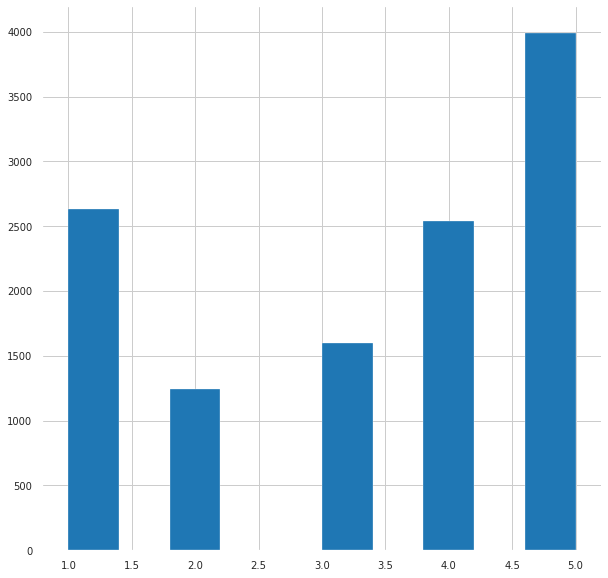

In [13]:
# Ahora, como se está manejando clasificación revisamos cuántas 
# veces está cada una de las clases para revisar el balanceo de los datos
# Con el histograma, se ven problemas de datos desbalanceados
data['problems_described'].hist(figsize = (10,10))

In [14]:
# Revisamos específicamente el número de datos sobre cada clase
data['problems_described'].value_counts()

5    3993
1    2629
4    2536
3    1600
2    1242
Name: problems_described, dtype: int64

In [15]:
# Revisamos el número de palabras que tienen las recetas médicas

data['numWords'] = 0
for i in range (len(data['problems_described'])):
  aux = len(data['medical_abstracts'][i].split(" "))
  data['numWords'][i] = aux


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


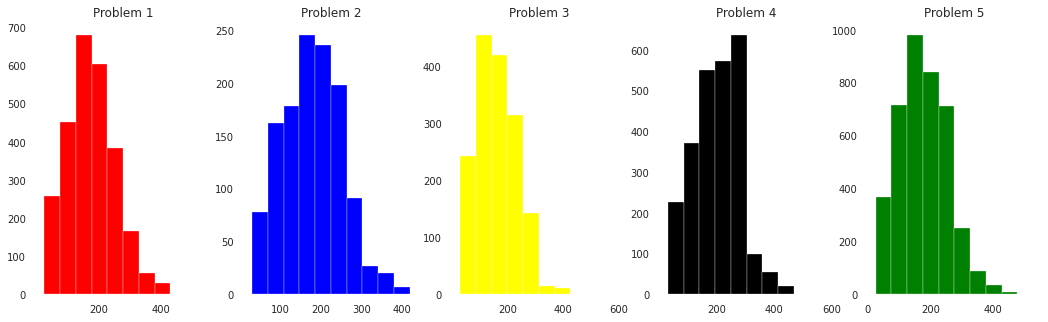

In [16]:
# Y ahora graficamos la longitud de los textos en palabras según el problema descrito
# PLOTTING WORD-COUNT
fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(1,5,figsize=(18,5))
train_words=data[data['problems_described']==1]['numWords']
ax1.hist(train_words,color='red')
ax1.set_title('Problem 1')
train_words2=data[data['problems_described']==2]['numWords']
ax2.hist(train_words2,color='blue')
ax2.set_title('Problem 2')
train_words3=data[data['problems_described']==3]['numWords']
ax3.hist(train_words3,color='yellow')
ax3.set_title('Problem 3')
train_words4=data[data['problems_described']==4]['numWords']
ax4.hist(train_words4,color='black')
ax4.set_title('Problem 4')
train_words5=data[data['problems_described']==5]['numWords']
ax5.hist(train_words5,color='green')
ax5.set_title('Problem 5')

plt.show()


## Parte 2: Procesamiento de los datos

### Limpieza de los datos
Se crean las funciones que ayudan a eliminar los caracteres que no son ASCII, se ponen todas en minúsculas para tener una comparación homogénea, se remueven los signos de puntuación, se ponen los números en una codificación de texto y finalmente, se eliminan las palabras que no aportan nada al significado. Estos pasos son los necesarios para ejecutar el algoritmo

In [17]:
# Hacemos undersampling
from collections import Counter

# Se parte el conjunto de datos en entrenamiento y test
X = data.drop(['problems_described'], axis=1)
Y = data['problems_described']

rus = RandomUnderSampler(random_state=42)
data['medical_abstracts'], data['problems_described'] = rus.fit_resample(X, Y)

data.dropna(inplace = True)
data['problems_described'].value_counts()

5.0    1242
1.0    1242
4.0    1242
2.0    1242
3.0    1242
Name: problems_described, dtype: int64

In [18]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    newWords = []
    """Convert all characters to lowercase from list of tokenized words"""
    for word in words:
      newWord = word.lower()
      newWords.append(newWord)
    return newWords
                      

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stop_words = set(stopwords.words('english'))
    newWords = [w for w in words if not w.lower() in stop_words]
 
    return newWords


def preprocessing(words):
    words = to_lowercase(words)
    words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

### Tokenización
En esta parte se aplican las funciones mencionadas anteriormente, con el fin de poder trabajar una representación adecuada de los datos

In [19]:
data['medical_abstracts'] = data['medical_abstracts'].apply(contractions.fix) #Aplica la corrección de las contracciones

In [20]:
data['words'] = data['medical_abstracts'].apply(word_tokenize).apply(preprocessing) #Aplica la eliminación del ruido
# Se revisa cómo quedaron las correcciones
data.head()

,medical_abstracts,problems_described,numWords,words
0,Translocation (9;22) is associated with extrem...,1.0,282,"[translocation, nine, twentytwo, associated, e..."
1,Comparison of methods for checking surgical ma...,1.0,108,"[comparison, methods, checking, surgical, marg..."
2,Monosomy 22 in rhabdoid or atypical tumors of ...,1.0,355,"[monosomy, twentytwo, rhabdoid, atypical, tumo..."
3,A simplified diagnostic approach to pheochromo...,1.0,69,"[simplified, diagnostic, approach, pheochromoc..."
4,Peptic ulcer perforation as the presentation o...,1.0,161,"[peptic, ulcer, perforation, presentation, zol..."


In [21]:
data['words']

0       [translocation, nine, twentytwo, associated, e...
1       [comparison, methods, checking, surgical, marg...
2       [monosomy, twentytwo, rhabdoid, atypical, tumo...
3       [simplified, diagnostic, approach, pheochromoc...
4       [peptic, ulcer, perforation, presentation, zol...
                              ...                        
6205    [differentiation, delayed, serologic, delayed,...
6206    [potential, value, hormone, receptor, assay, c...
6207    [resuscitation, patients, cardiac, arrest, amb...
6208    [longterm, clinical, results, ionescushiley, p...
6209    [nb4, maturation, inducible, cell, line, fifte...
Name: words, Length: 6210, dtype: object

### Etapa de normalización
Esta etapa simplifica la cantidad de palabras. Al hacer stemming de las palabras se reducen a lo que les da el significado, y cuando se hace lemmatizing se busca que se encuentre una palabra con la cual se acepten las demás palabras flexionadas

In [22]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    newWords = []
    ps = PorterStemmer()
    # choose some words to be stemmed
    for w in words:
      newWords.append(ps.stem(w))
    return newWords

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    newWords = []
    for w in words:
      newWords.append(lemmatizer.lemmatize(w))
    return newWords


def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas

data['words'] = data['words'].apply(stem_and_lemmatize) #Aplica lematización y Eliminación de Prefijos y Sufijos.
data.head()

,medical_abstracts,problems_described,numWords,words
0,Translocation (9;22) is associated with extrem...,1.0,282,"[transloc, nine, twentytwo, associ, extrem, po..."
1,Comparison of methods for checking surgical ma...,1.0,108,"[comparison, method, check, surgic, margin, su..."
2,Monosomy 22 in rhabdoid or atypical tumors of ...,1.0,355,"[monosomi, twentytwo, rhabdoid, atyp, tumor, b..."
3,A simplified diagnostic approach to pheochromo...,1.0,69,"[simplifi, diagnost, approach, pheochromocytom..."
4,Peptic ulcer perforation as the presentation o...,1.0,161,"[peptic, ulcer, perfor, present, zollingerelli..."


### Selección de campos
Una de las cosas que se debe hacer es balancear las clases, con el fin de que no se tengan problemas de sesgos en el modelo 

In [23]:
# En esta parte, creamos una columna adicional en donde están las listas de las palabras
data['words'] = data['words'].apply(lambda x: ' '.join(map(str, x)))
data

,medical_abstracts,problems_described,numWords,words
0,Translocation (9;22) is associated with extrem...,1.0,282,transloc nine twentytwo associ extrem poor pro...
1,Comparison of methods for checking surgical ma...,1.0,108,comparison method check surgic margin surgic m...
2,Monosomy 22 in rhabdoid or atypical tumors of ...,1.0,355,monosomi twentytwo rhabdoid atyp tumor brain c...
3,A simplified diagnostic approach to pheochromo...,1.0,69,simplifi diagnost approach pheochromocytoma re...
4,Peptic ulcer perforation as the presentation o...,1.0,161,peptic ulcer perfor present zollingerellison s...
...,...,...,...,...
6205,The differentiation of delayed serologic and d...,5.0,344,differenti delay serolog delay hemolyt transfu...
6206,Potential value of hormone receptor assay in c...,5.0,100,potenti valu hormon receptor assay carcinoma s...
6207,Resuscitation of patients with cardiac arrest ...,5.0,83,resuscit patient cardiac arrest ambul staff ex...
6208,Long-term clinical results with the Ionescu-Sh...,5.0,251,longterm clinic result ionescushiley pericardi...


In [24]:
# Tomamos los datos de la X, que son las listas, y la Y que es el diagnóstico
X_data, y_data = data['words'],data['problems_described']
X_data

0       transloc nine twentytwo associ extrem poor pro...
1       comparison method check surgic margin surgic m...
2       monosomi twentytwo rhabdoid atyp tumor brain c...
3       simplifi diagnost approach pheochromocytoma re...
4       peptic ulcer perfor present zollingerellison s...
                              ...                        
6205    differenti delay serolog delay hemolyt transfu...
6206    potenti valu hormon receptor assay carcinoma s...
6207    resuscit patient cardiac arrest ambul staff ex...
6208    longterm clinic result ionescushiley pericardi...
6209    nb4 matur induc cell line fifteen seventeen ma...
Name: words, Length: 6210, dtype: object

In [25]:
# Se elige la representación de la bolsa de palabras, en la cual tenemos una matriz
# En esta matriz, cada entrada de X_dummy[i,j] nos va a indicar en 
# el documento i cuántas veces la palabra j está presente
dummy = CountVectorizer()

X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)
# Ahora, se debe hacer el under sampling para balancear las clases


X_dummy = dummy.fit_transform(X_train)
print(X_dummy.shape)
X_dummy.toarray()[0]


(4968, 39420)


array([0, 0, 0, ..., 0, 0, 0])

In [26]:
X_dummy = dummy.fit_transform(X_train)

In [27]:
# Obtenemos el vocabulario correspondiente
dummy.vocabulary_.get(u'algorithm')

3910

In [28]:
# Representación tf-idf
# En esta representación, para no estar sesgados por la longitud de los textos, 
# se usa la frecuencia relativa con esta representación

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_dummy)
X_train_tfidf.shape

(4968, 39420)

## Parte 3: Implementación de los modelos

### Primer algoritmo: Naïve Bayes Classifier
Este algoritmo es ampliamente recomendado por SciKit Learn, pues se adapta bien a las clasificaciones multinomiales

In [29]:
# Importamos la librería respectiva
from sklearn.naive_bayes import MultinomialNB

# Se entrena el modelo con la representación tf-idf
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [30]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

In [31]:
# Prueba del modelo con los datos de test
X_new_counts = dummy.transform(X_test)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

# Predicted nos dirá el vector de resultados que envía el modelo
predicted = clf.predict(X_new_tfidf)

In [32]:
# Se simplifica la creación del modelo mediante un Pipeline
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB())])

In [33]:
# Entrenamos el modelo con el pipeline
text_clf.fit(X_train, Y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [34]:
# Evaluamos el desempeño del modelo
# En este caso se genera un vector de 1s y 0s, y se determina la media para 
# ver un porcentaje de aceptación
predicted = text_clf.predict(X_test)
np.mean(predicted == Y_test)

0.6417069243156199

In [35]:
max = 0

# Busqueda del mejor hiperparametro alpha por medio de prueba y error del campo de busqueda dterministico.
for i in np.arange(0, 1, 0.01):

  text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=i))])
  text_clf.fit(X_train, Y_train)
  predicted = text_clf.predict(X_test)
  r = np.mean(predicted == Y_test)

  if r > max:
    max = r
    print(f"{r} --> alpha: {i}")

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


0.5024154589371981 --> alpha: 0.0
0.5925925925925926 --> alpha: 0.01
0.5990338164251208 --> alpha: 0.02
0.6022544283413849 --> alpha: 0.03
0.6038647342995169 --> alpha: 0.04
0.6103059581320451 --> alpha: 0.05
0.6135265700483091 --> alpha: 0.06
0.6143317230273752 --> alpha: 0.09
0.6159420289855072 --> alpha: 0.1
0.6199677938808373 --> alpha: 0.11
0.6223832528180354 --> alpha: 0.12
0.6231884057971014 --> alpha: 0.13
0.6247987117552335 --> alpha: 0.14
0.6264090177133655 --> alpha: 0.15
0.6280193236714976 --> alpha: 0.17
0.6288244766505636 --> alpha: 0.18
0.6296296296296297 --> alpha: 0.19
0.6304347826086957 --> alpha: 0.2
0.6336553945249598 --> alpha: 0.21
0.6360708534621579 --> alpha: 0.26
0.6384863123993558 --> alpha: 0.27
0.6392914653784219 --> alpha: 0.35000000000000003
0.6400966183574879 --> alpha: 0.4
0.6409017713365539 --> alpha: 0.41000000000000003
0.6417069243156199 --> alpha: 0.44
0.642512077294686 --> alpha: 0.46


In [36]:
# Mejor modelo
text_clf = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('clf', MultinomialNB(alpha=0.46))])
text_clf.fit(X_train, Y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == Y_test)

0.642512077294686

In [37]:
text_clf.get_params()

{'clf': MultinomialNB(alpha=0.46),
 'clf__alpha': 0.46,
 'clf__class_prior': None,
 'clf__fit_prior': True,
 'memory': None,
 'steps': [('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', MultinomialNB(alpha=0.46))],
 'tfidf': TfidfTransformer(),
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'vect': CountVectorizer(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'verbose': False}

In [38]:
# Obtenemos a detalle las métricas del modelo
from sklearn import metrics
print(metrics.classification_report(Y_test, predicted))

metrics.confusion_matrix(Y_test, predicted)

              precision    recall  f1-score   support

         1.0       0.66      0.78      0.71       245
         2.0       0.71      0.80      0.75       245
         3.0       0.69      0.62      0.65       255
         4.0       0.64      0.86      0.73       243
         5.0       0.38      0.19      0.25       254

    accuracy                           0.64      1242
   macro avg       0.61      0.65      0.62      1242
weighted avg       0.61      0.64      0.62      1242



array([[190,  10,  17,   9,  19],
       [ 18, 196,   6,  15,  10],
       [ 27,  11, 157,  30,  30],
       [  4,   5,   8, 208,  18],
       [ 49,  56,  41,  61,  47]])

### Segundo algoritmo: Support Vector Machine
Este algoritmo es mejor para la clasificaión de textos, no obstante, es un poco más lento que el primer clasificador usado en este proyecto

In [39]:
# Intentamos con otro algoritmo 
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
                     ])

text_clf.fit(X_train, Y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == Y_test)

0.6610305958132046

In [40]:
# Obtenemos a detalle las métricas del modelo
print(metrics.classification_report(Y_test, predicted))
metrics.confusion_matrix(Y_test, predicted)

              precision    recall  f1-score   support

         1.0       0.62      0.82      0.71       245
         2.0       0.70      0.81      0.75       245
         3.0       0.67      0.69      0.68       255
         4.0       0.68      0.90      0.78       243
         5.0       0.51      0.11      0.18       254

    accuracy                           0.66      1242
   macro avg       0.64      0.67      0.62      1242
weighted avg       0.64      0.66      0.62      1242



array([[202,  12,  18,   7,   6],
       [ 25, 198,   9,  12,   1],
       [ 30,  10, 176,  23,  16],
       [  7,   8,   7, 218,   3],
       [ 60,  55,  53,  59,  27]])

In [41]:
# Podemos ver que el desempeño de este algoritmo es ampliamente mejor a los otros 
# Nota: hacer scroll para revisar el desempeño de los árboles de decisión
# Es por esto que se decide realizar un ajuste de hiperparámetros solamente a este 
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
              'clf__loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)
gs_clf = gs_clf.fit(X_train, Y_train)

In [42]:
# Revisamos el puntaje del mejor modelo
gs_clf.best_score_

0.658208667918893

In [43]:
# Vemos los puntajes de las combinaciones tratadas
for param_name in sorted(parameters.keys()):
  print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))

clf__alpha: 0.001
clf__loss: 'log'
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [44]:
# Probamos los resultados del nuevo modelo 
predicted = gs_clf.predict(X_test)
np.mean(predicted == Y_test)

0.6570048309178744

In [45]:
# Obtenemos a detalle las métricas del modelo
print(metrics.classification_report(Y_test, predicted))
metrics.confusion_matrix(Y_test, predicted)

              precision    recall  f1-score   support

         1.0       0.66      0.78      0.71       245
         2.0       0.69      0.79      0.74       245
         3.0       0.64      0.69      0.67       255
         4.0       0.71      0.84      0.77       243
         5.0       0.47      0.20      0.28       254

    accuracy                           0.66      1242
   macro avg       0.63      0.66      0.63      1242
weighted avg       0.63      0.66      0.63      1242



array([[190,  13,  25,   7,  10],
       [ 21, 193,  11,  12,   8],
       [ 23,  12, 177,  17,  26],
       [  5,   8,  11, 205,  14],
       [ 51,  52,  52,  48,  51]])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


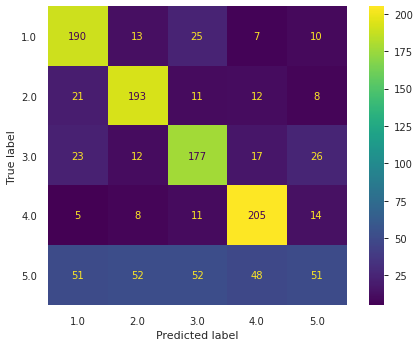

In [46]:
# Se puede visualizar la matriz de confusión
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(gs_clf, X_test, Y_test)  
plt.show()  

#### Manejo de resultados
Teniendo en cuenta que este es el modelo final que se le recomendará al negocio, se tratan los datos de los resultados para entregarle al negocio las conclusiones más relevantes de lo que aprendió el modelo

In [47]:
# En esta primera parte, filtramos los datos test para que salgan:
# las palabras y la clase en caso de que haya sido correcta
d = {'Words': X_test, 'PredictedClass': predicted, 'ActualClass':Y_test} 
respuesta = pd.DataFrame(data=d)

# Eliminamos los datos en los que la predicción no fue correcta
respuesta.loc[respuesta.PredictedClass != respuesta.ActualClass, "ActualClass"] = np.nan
respuesta.dropna(inplace = True)
respuesta.head(5)


,Words,PredictedClass,ActualClass
4714,arteri protect neglect crucial therapeut goal ...,4.0,4.0
2140,druginduc colon pseudoobstruct report case col...,2.0,2.0
2537,limit brain toler daili increment serum sodium...,3.0,3.0
462,classif endometri cell cervic cytolog one hund...,1.0,1.0
4148,secondari prevent acut myocardi infarct betabl...,4.0,4.0


In [48]:
# Ahora, hacemos un diccionario en donde para cada clase
# Dentro de cada diccionario, van a estar las palabras presentes en cada clase
# Y el número de veces que están presentes globalmente
wordsByClass = {}
for i in range(1,6):
  wordsByClass[i] = {}

#for i in range(len(respuesta['Words'])):
for i in respuesta.index:
  auxWords = respuesta['Words'][i].split(" ")
  diagnose = respuesta['PredictedClass'][i]
  for word in auxWords:
    wordsByClass[diagnose][word] = 0
  
  for word in auxWords:
    wordsByClass[diagnose][word] += 1

In [49]:
# Ahora, creamos el DataFrame correspondiente para poder exportarlo a csv

diagnoseList = []
wordList = []
valuesList = []

for diagnose in wordsByClass:
  for word in wordsByClass[diagnose]:
    diagnoseList.append(diagnose)
    wordList.append(word)
    valuesList.append(wordsByClass[diagnose][word])

results = {'Diagnose': diagnoseList, 'Word': wordList, 'Occurrences':valuesList} 
resultsDf = pd.DataFrame(data=results)
resultsDf.head(5)


,Diagnose,Word,Occurrences
0,1,classif,1
1,1,endometri,10
2,1,cell,8
3,1,cervic,1
4,1,cytolog,3


In [50]:
# Exportamos el resultado a un csv para darle manejo en el tablero de control
resultsDf.to_csv('results.csv')

#### Etapa de exportación de los datos con los cuales se entrenaron los modelos
Con el fin de cumplir con el requerimiento, se exportan a csv los datos transformados como palabras, además de la matriz con los datos después de la transformación tf_idf 

In [52]:
# En esta celda se exportan los datos correspondientes a los datos de entrenamiento
trainData = {'Words': X_train, 'Issue': Y_train}
trainDataDF = pd.DataFrame(data=trainData)
trainDataDF.to_csv('dataTrain.csv')

In [60]:
# En esta parte, se exporta la representación tf_idf del conjunto train
X_new_tfidfDF = pd.DataFrame(X_new_tfidf, )
X_new_tfidfDF.to_csv('dataTF_IDF.csv')

### Tercer algoritmo: Árboles de Decisión
Teniendo en cuenta la confiabilidad de este algoritmo, se decide implementarlo

In [46]:
# Crear el objeto de arbol de decisión. Utilicemos como criterio de pureza la entropía.
from sklearn.tree import DecisionTreeClassifier
arbol = DecisionTreeClassifier(criterion='entropy', random_state=0)
# Entrenar el modelo de arbol de decisión con los datos de entrenamiento
arbol = arbol.fit(X_train_tfidf, Y_train)
# Determinamos las predicciones del modelo sobre el conjunto test.
# Prueba del modelo con los datos de test
X_new_counts2 = dummy.transform(X_test)
X_new_tfidf2 = tfidf_transformer.transform(X_new_counts2)

predicted = clf.predict(X_new_tfidf2)
np.mean(predicted == Y_test)

0.6417069243156199

In [47]:
arbol.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

In [48]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[None, 5, 10],'min_samples_split':[2, 3]}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol2 = DecisionTreeClassifier(random_state=0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol2, param_grid, cv=particiones)

# Ajuste del modelo
mejor_modelo.fit(X_train_tfidf, Y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 3]})

In [49]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 3}

In [50]:
# Determinamos las predicciones del modelo sobre el conjunto test.
# Prueba del modelo con los datos de test
X_new_counts2 = dummy.transform(X_test)
X_new_tfidf2 = tfidf_transformer.transform(X_new_counts2)

predicted = mejor_modelo.predict(X_new_tfidf2)
np.mean(predicted == Y_test)

0.4750402576489533

In [51]:
# Se consultan las métricas del negocio más a detalle 
print(metrics.classification_report(Y_test, predicted))
metrics.confusion_matrix(Y_test, predicted)

              precision    recall  f1-score   support

         1.0       0.53      0.56      0.55       245
         2.0       0.60      0.58      0.59       245
         3.0       0.46      0.43      0.44       255
         4.0       0.60      0.61      0.61       243
         5.0       0.20      0.21      0.21       254

    accuracy                           0.48      1242
   macro avg       0.48      0.48      0.48      1242
weighted avg       0.48      0.48      0.48      1242



array([[138,  19,  36,  11,  41],
       [ 34, 142,  22,   8,  39],
       [ 32,  17, 109,  29,  68],
       [  6,  12,  19, 148,  58],
       [ 51,  48,  53,  49,  53]])

In [ ]:
# Podemos ver que la búsqueda de hiper parámetros no mejoró el rendimiento del modelo, 
# se deja para que se pueda evidenciar su realización, sin embargo, se ignora para 
# la toma de decisiones